In [1]:
import numpy as np
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
import random as rn
from keras import backend as K
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise
import time
tf.set_random_seed(30)
np.random.seed(30)
rn.seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet
from keras.applications.inception_v3 import InceptionV3

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
train_path ='./Project_data/train'
val_path = './Project_data/val'
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
timetaken=[]
class Builder():
    
    def __init__(self,modelname,model,train_size=len(train_doc),val_size=len(val_doc),image_shape=(224,224,3),
                 sequence_length=20,start_frame=5,batch_size=8,epochs=25,data_augment=False):
        self.train_samples = train_size
        self.val_samples = val_size
        self.image_height=image_shape[0]
        self.image_width=image_shape[1]
        self.channels=image_shape[2]
        self.num_classes=5
        self.start_frame=start_frame
        self.sequence_length=sequence_length
        self.batch_size=batch_size
        self.epochs = epochs
        self.modelname=modelname
        self.model = model
        self.data_augment = data_augment
        print("Image shape: ",self.channels)
           
    def generator(self,source_path, folder_list, augment=False):
        img_idx = list(range(self.start_frame,self.start_frame+self.sequence_length))
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.generate_batch(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.generate_batch(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    def rotate(self,img, angle, center = None, scale = 1.0):
        (h, w) = img.shape[:2]

        if center is None:
            center = (w / 2, h / 2)

        # Perform the rotation
        M = cv2.getRotationMatrix2D(center, angle, scale)
        rotated = cv2.warpAffine(img, M, (w, h))

        return rotated
    
    def generate_batch(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        if remaining_seq!=0: 
            seq_len = remaining_seq
        else:
            seq_len = batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width,))
            
                for j in range(self.channels):
                    batch_data[folder,idx,:,:,j] = (image_resized[:,:,j])/255
            
                if (augment):
                    noise_img = random_noise(image, mode='gaussian')
#                     # The above function returns a floating-point image
#                     # on the range [0, 1], thus we changed it to 'uint8'
#                     # and from [0,255]
                    noisy = np.array(255*noise_img, dtype = 'uint8')
                    image_resized=cv2.resize(noisy,(self.image_height,self.image_width,))
                    for j in range(self.channels):
                        batch_data_aug[folder,idx,:,:,j] = (image_resized[:,:,j])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self,pick_checkpoint=(False,'')):
        train_generator = self.generator(train_path,train_doc,augment=True)
        val_generator = self.generator(val_path,val_doc)

        model_name = self.modelname + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, 
                                     save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)
        callbacks_list = [checkpoint, LR]

        if (self.train_samples%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.train_samples//self.batch_size) + 1

        if (self.val_samples%self.batch_size) == 0:
            validation_steps = int(self.val_samples/self.batch_size)
        else:
            validation_steps = (self.val_samples//self.batch_size) + 1
        if(~pick_checkpoint[0]):
            result=self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        else:
            self.model = load_model(pick_checkpoint[1])
            result=self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(result.history['loss'])   
        axes[0].plot(result.history['val_loss'])
        axes[0].legend(['loss','val_loss'])
        axes[1].plot(result.history['categorical_accuracy'])   
        axes[1].plot(result.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
        
        return result


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 - CNN- LSTM Model (No Data Augmentation)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 200, 200, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200, 200, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 100, 100, 32)  4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 50, 50, 64)    18496     
__________

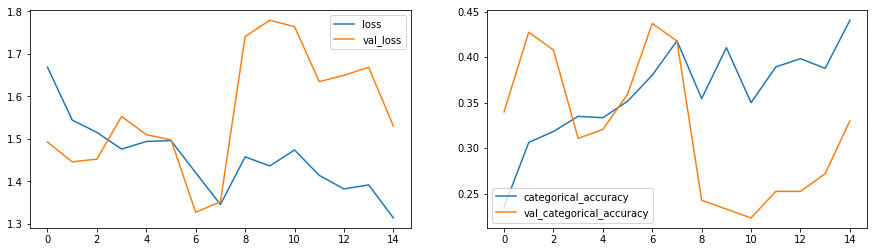

In [6]:
start_frame=5
seq_len = 15
im_height = 200
im_width = 200
channels = 3
epochs=15
batch_size=16
model1 = Sequential()

model1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

model1.add(TimeDistributed(Flatten()))


model1.add(LSTM(128))
model1.add(Dropout(0.5))

model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


print(model1.summary())

cnn_lstm1=Builder('cnnlstm1',model1,image_shape=(im_height,im_width,channels),sequence_length=seq_len,
                  start_frame=start_frame,batch_size=batch_size,epochs=epochs)
t0 = time.time()
nn_lstm1_result=cnn_lstm1.train_model(pick_checkpoint=(True,"./cnnlstm1_2020-03-2912_25_16.721832/model-00008-1.40801-0.38462-1.29570-0.45631.h5"))
timetaken.append(['cnnlstm1',batch_size,time.time()-t0])

### Model 2 - CNN- LSTM Model (With Data Augmentation: Affine warp)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 200, 200, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200, 200, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 100, 100, 32)  4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 50, 50, 64)    18496     
__________

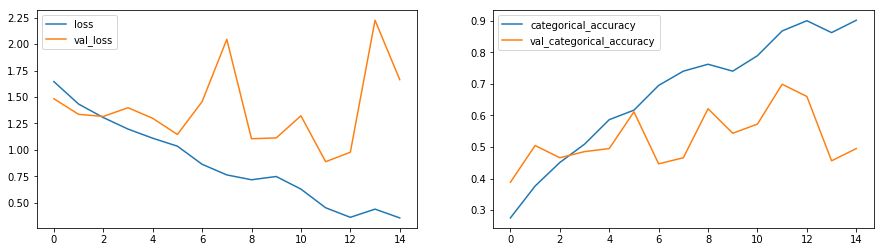

In [8]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
epochs=15
batch_size=16
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Flatten()))


model2.add(LSTM(128))
model2.add(Dropout(0.5))

model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


cnn_lstm2=Builder('cnnlstm2',model2,image_shape=(im_height,im_width,channels),
                  batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
t0=time.time()
cnn_lstm2_result=cnn_lstm2.train_model()
timetaken.append(['cnnlstm2',batch_size,time.time()-t0])

### Model 2 - CNN- GRU Model (With Data Augmentation)

#### If GRU performs then we would have taken first step to reduce model size


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 200, 200, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200, 200, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 100, 100, 32)  4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 50, 50, 64)    18496     
__________

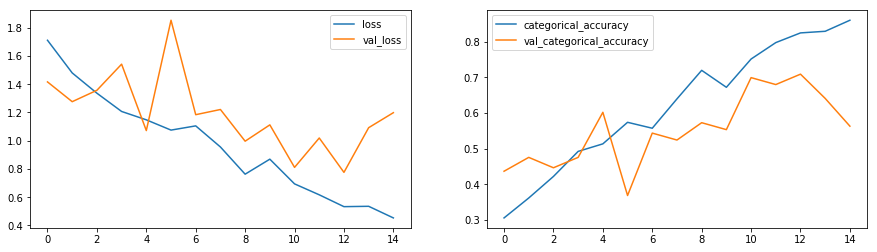

In [10]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=16
epochs=15
model3 = Sequential()

model3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Flatten()))


model3.add(GRU(128))
model3.add(Dropout(0.5))

model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])




cnn_gru1=Builder('cnngru1',model3,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
t0=time.time()
cnn_gru1_result=cnn_gru1.train_model()
timetaken.append(['cnngru1',batch_size,time.time()-t0])

In [14]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_58 (TimeDis (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_59 (TimeDis (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_60 (TimeDis (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_61 (TimeDis (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_62 (TimeDis (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 15, 30, 30, 64)    18496     
__________

#### Observation 
GRU and LSTM perform almost equally on the validation score.
Validation_loss v Epochs is not a smooth decline but has spikes in between.
Also Validation loss starts increasing after the 10th epoch. So will switch to 10 epochs going forward
#### Next step
- Trying to vary hyperparameters
    - increase batch_size
    - reduce GRU cells
    - reduce one CNN layer
    - switch to 10 epochs


batch size =  32
batch size =  32
Epoch 1/10
21/21 [==============================] - 237s 11s/step - loss: 1.7946 - categorical_accuracy: 0.2587 - val_loss: 1.5010 - val_categorical_accuracy: 0.3277

Epoch 00001: val_loss improved from inf to 1.50096, saving model to cnngru2_2020-03-3001_05_28.561841/model-00001-1.79129-0.25867-1.50096-0.32773.h5
Epoch 2/10
21/21 [==============================] - 225s 11s/step - loss: 1.5907 - categorical_accuracy: 0.3191 - val_loss: 1.3603 - val_categorical_accuracy: 0.4790

Epoch 00002: val_loss improved from 1.50096 to 1.36027, saving model to cnngru2_2020-03-3001_05_28.561841/model-00002-1.58554-0.32127-1.36027-0.47899.h5
Epoch 3/10
21/21 [==============================] - 234s 11s/step - loss: 1.4495 - categorical_accuracy: 0.3934 - val_loss: 1.2878 - val_categorical_accuracy: 0.4958

Epoch 00003: val_loss improved from 1.36027 to 1.28780, saving model to cnngru2_2020-03-3001_05_28.561841/model-00003-1.44257-0.39593-1.28780-0.49580.h5
Epoch 4/10

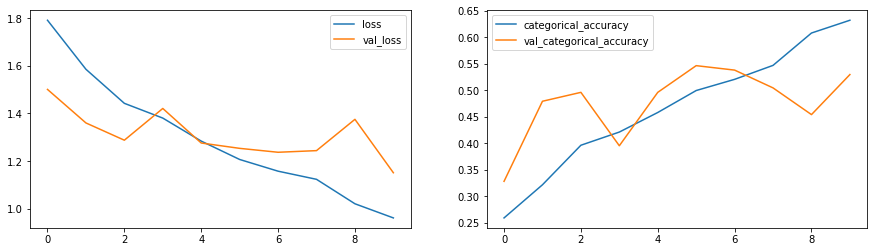

In [18]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=32
epochs=10
model4 = Sequential()

model4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

# model4.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
# model4.add(TimeDistributed(BatchNormalization()))
# model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))


model4.add(GRU(64))
model4.add(Dropout(0.5))

model4.add(Dense(64,activation='relu'))
model4.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_gru2=Builder('cnngru2',model4,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
t0=time.time()
cnn_gru2_result=cnn_gru2.train_model()
timetaken.append(['cnngru2',batch_size,time.time()-t0])

In [19]:
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_141 (TimeDi (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_142 (TimeDi (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_143 (TimeDi (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_144 (TimeDi (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_145 (TimeDi (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_146 (TimeDi (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_147 (TimeDi (None, 15, 30, 30, 64)    18496     
__________

#### Observation
A decline in validation accuracy suggests, removing a CNN layer and reducing GRU cells together was a bad idea. So let's add more GRU cells.

batch size = batch size =  32
Epoch 1/10
 32
21/21 [==============================] - 227s 11s/step - loss: 1.8096 - categorical_accuracy: 0.2567 - val_loss: 1.5087 - val_categorical_accuracy: 0.3361

Epoch 00001: val_loss improved from inf to 1.50869, saving model to cnngru3_2020-03-3002_03_40.403532/model-00001-1.80790-0.25716-1.50869-0.33613.h5
Epoch 2/10
21/21 [==============================] - 218s 10s/step - loss: 1.5172 - categorical_accuracy: 0.3470 - val_loss: 1.4460 - val_categorical_accuracy: 0.3697

Epoch 00002: val_loss improved from 1.50869 to 1.44598, saving model to cnngru3_2020-03-3002_03_40.403532/model-00002-1.51359-0.34842-1.44598-0.36975.h5
Epoch 3/10
21/21 [==============================] - 219s 10s/step - loss: 1.4172 - categorical_accuracy: 0.4241 - val_loss: 1.3353 - val_categorical_accuracy: 0.4286

Epoch 00003: val_loss improved from 1.44598 to 1.33531, saving model to cnngru3_2020-03-3002_03_40.403532/model-00003-1.40558-0.42760-1.33531-0.42857.h5
Epoch 4/10

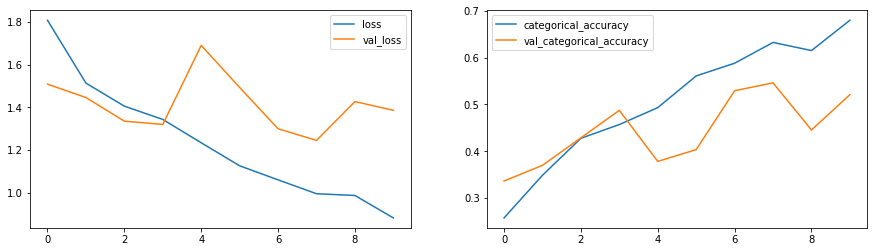

In [22]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=32
epochs=10
model5 = Sequential()

model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

# model5.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
# model5.add(TimeDistributed(BatchNormalization()))
# model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))


model5.add(GRU(128))
model5.add(Dropout(0.5))

model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.5))

model5.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_gru3=Builder('cnngru3',model5,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
t0=time.time()
cnn_gru3_result=cnn_gru3.train_model()
timetaken.append(['cnngru3',batch_size,time.time()-t0])

In [23]:
print(model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_157 (TimeDi (None, 15, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_158 (TimeDi (None, 15, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_159 (TimeDi (None, 15, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_160 (TimeDi (None, 15, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_161 (TimeDi (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_162 (TimeDi (None, 15, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_163 (TimeDi (None, 15, 30, 30, 64)    18496     
__________

#### So far we can see clearly:
    - Data augmentation (using noisy samples) helps improve validation accuracy but increases training time ~5x
    - GRU takes slightly lesser training time than LSTM and performs equally on validation score.
    - Batch_size 20 seems fine as increasing to 32 or more throws a "MemoryError"
    MemoryError                               Traceback (most recent call last)
    <ipython-input-104-940d33be2854> in <module>()
         55                  batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
     56 t0=time.time()
---> 57 cnn_gru3_gray_result=cnn_gru3_gray.train_model()
#### Next Steps:
    - Use GRU and Try a quicker augmentation technique -> Gaussian noise using skimage
    - Validation accuracy is still increasing around 10th epoch so lets see if I increase more epochs.

Image shape:  3
Epoch 1/20
21/21 [==============================] - 147s 7s/step - loss: 1.4988 - categorical_accuracy: 0.3284 - val_loss: 1.3217 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.32167, saving model to cnngru4_2020-03-3008_34_17.044020/model-00001-1.50013-0.32730-1.32167-0.45000.h5
Epoch 2/20
21/21 [==============================] - 142s 7s/step - loss: 1.3509 - categorical_accuracy: 0.3905 - val_loss: 1.2512 - val_categorical_accuracy: 0.5300

Epoch 00002: val_loss improved from 1.32167 to 1.25121, saving model to cnngru4_2020-03-3008_34_17.044020/model-00002-1.35151-0.38989-1.25121-0.53000.h5
Epoch 3/20
21/21 [==============================] - 144s 7s/step - loss: 1.2793 - categorical_accuracy: 0.4233 - val_loss: 1.1887 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss improved from 1.25121 to 1.18872, saving model to cnngru4_2020-03-3008_34_17.044020/model-00003-1.28154-0.42232-1.18872-0.51000.h5
Epoch 4/20
21/21 [=============

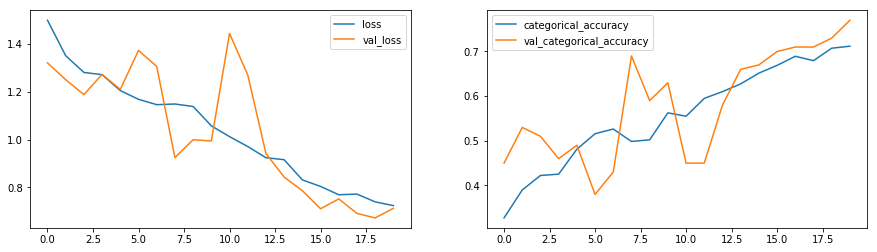

In [10]:
start_frame = 5
seq_len = 20
im_height = 120
im_width = 120
channels = 3
batch_size=32
epochs=20
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(seq_len,im_height,im_width,channels)))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

# model6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model6.add(TimeDistributed(BatchNormalization()))
# model6.add(TimeDistributed(MaxPooling2D((2, 2))))

# model6.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
# model6.add(TimeDistributed(BatchNormalization()))
# model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Flatten()))


model6.add(GRU(128))
model6.add(Dropout(0.25))

# model6.add(Dense(128,activation='relu'))
# model6.add(Dropout(0.25))

# model6.add(Dense(64,activation='relu'))
# model6.add(Dropout(0.25))

model6.add(Dense(32,activation='relu'))
model6.add(Dropout(0.25))

model6.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

cnn_gru4=Builder('cnngru4',model6,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,data_augment=True)
t0=time.time()
cnn_gru4_result=cnn_gru4.train_model()
timetaken.append(['cnngru4',batch_size,time.time()-t0])

In [11]:
print(model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_40 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_42 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, 20, 30, 30, 64)    18496     
__________

# Transfer Learning - Using InceptionV3 

#### InceptionV3 with non-trainable layers

87916544/87910968 [==============================] - 7s 0us/step
Image shape:  3
Epoch 1/20
42/42 [==============================] - 118s 3s/step - loss: 1.9967 - categorical_accuracy: 0.2536 - val_loss: 1.6242 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 1.62417, saving model to inc_gru1_2020-03-3009_23_01.319624/model-00001-1.99871-0.25415-1.62417-0.19000.h5
Epoch 2/20
42/42 [==============================] - 99s 2s/step - loss: 1.7265 - categorical_accuracy: 0.2527 - val_loss: 1.6064 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss improved from 1.62417 to 1.60637, saving model to inc_gru1_2020-03-3009_23_01.319624/model-00002-1.72822-0.25415-1.60637-0.29000.h5
Epoch 3/20
42/42 [==============================] - 109s 3s/step - loss: 1.6097 - categorical_accuracy: 0.2894 - val_loss: 1.6052 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss improved from 1.60637 to 1.60522, saving model to inc_gru1_2020-03-3009_23_01.319624/model-00003

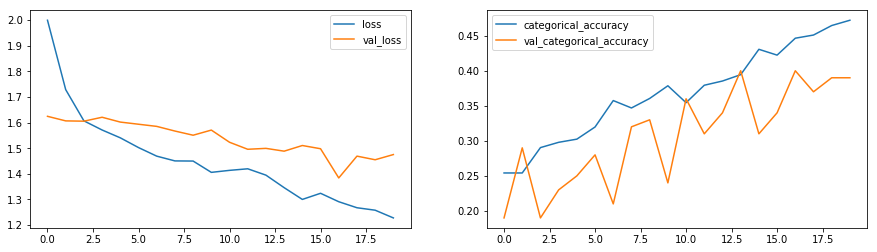

In [12]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=16
epochs=20

model7 = Sequential()
model7.add(TimeDistributed(InceptionV3(weights='imagenet', include_top=False),input_shape=(seq_len,im_height,im_width,channels)))
for layer in model7.layers:
    layer.trainable = False


model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
model7.add(TimeDistributed(Flatten()))

model7.add(GRU(128))
model7.add(Dropout(0.5))

model7.add(Dense(64,activation='relu'))
model7.add(Dropout(0.5))

model7.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

inc_gru1=Builder('inc_gru1',model7,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,
                 data_augment=True)
t0=time.time()
inc_gru1_result=inc_gru1.train_model()
timetaken.append(['inc_gru1',batch_size,time.time()-t0])

#### InceptionV3 with trainable layers

Image shape:  3
Epoch 1/16
83/83 [==============================] - 177s 2s/step - loss: 1.8830 - categorical_accuracy: 0.2596 - val_loss: 1.5081 - val_categorical_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 1.50813, saving model to inc_gru2_2020-03-3015_04_54.968312/model-00001-1.88341-0.25943-1.50813-0.34000.h5
Epoch 2/16
83/83 [==============================] - 105s 1s/step - loss: 1.6601 - categorical_accuracy: 0.3085 - val_loss: 1.3143 - val_categorical_accuracy: 0.4200

Epoch 00002: val_loss improved from 1.50813 to 1.31433, saving model to inc_gru2_2020-03-3015_04_54.968312/model-00002-1.66004-0.30845-1.31433-0.42000.h5
Epoch 3/16
83/83 [==============================] - 115s 1s/step - loss: 1.4976 - categorical_accuracy: 0.3637 - val_loss: 1.1218 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 1.31433 to 1.12175, saving model to inc_gru2_2020-03-3015_04_54.968312/model-00003-1.49783-0.36350-1.12175-0.59000.h5
Epoch 4/16
83/83 [==========

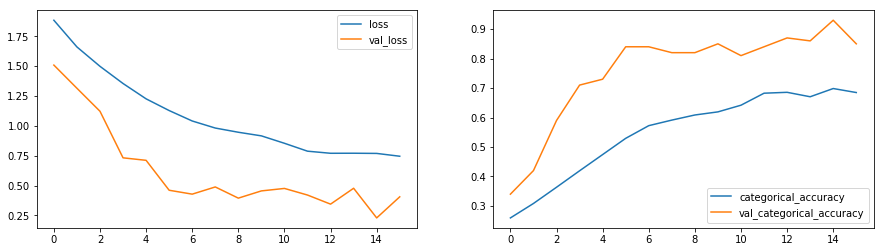

In [20]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=8
epochs=16

model8 = Sequential()
model8.add(TimeDistributed(InceptionV3(weights='imagenet', include_top=False),input_shape=(seq_len,im_height,im_width,channels)))
# for layer in model8.layers:
#     layer.trainable = False


model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(TimeDistributed(Flatten()))

model8.add(GRU(128))
model8.add(Dropout(0.5))

model8.add(Dense(64,activation='relu'))
model8.add(Dropout(0.5))

model8.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(lr=0.0002)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

inc_gru2=Builder('inc_gru2',model8,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,
                 data_augment=True)
t0=time.time()
inc_gru2_result=inc_gru2.train_model()
timetaken.append(['inc_gru2',batch_size,time.time()-t0])

In [21]:
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 15, 2, 2, 2048)    21802784  
_________________________________________________________________
time_distributed_40 (TimeDis (None, 15, 2, 2, 2048)    8192      
_________________________________________________________________
time_distributed_41 (TimeDis (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 15, 2048)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 128)               835968    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
__________

#### MobileNets with trainable parameters (In an attempt to further reduce model size)

Image shape:  3
Epoch 1/15
83/83 [==============================] - 153s 2s/step - loss: 1.9364 - categorical_accuracy: 0.2577 - val_loss: 1.3991 - val_categorical_accuracy: 0.4300

Epoch 00001: val_loss improved from inf to 1.39911, saving model to mbn_gru1_2020-03-3014_31_17.580974/model-00001-1.93665-0.25792-1.39911-0.43000.h5
Epoch 2/15
83/83 [==============================] - 101s 1s/step - loss: 1.5764 - categorical_accuracy: 0.3268 - val_loss: 1.2302 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.39911 to 1.23017, saving model to mbn_gru1_2020-03-3014_31_17.580974/model-00002-1.57693-0.32655-1.23017-0.55000.h5
Epoch 3/15
83/83 [==============================] - 114s 1s/step - loss: 1.4214 - categorical_accuracy: 0.4029 - val_loss: 0.9581 - val_categorical_accuracy: 0.6600

Epoch 00003: val_loss improved from 1.23017 to 0.95814, saving model to mbn_gru1_2020-03-3014_31_17.580974/model-00003-1.42182-0.40271-0.95814-0.66000.h5
Epoch 4/15
83/83 [==========

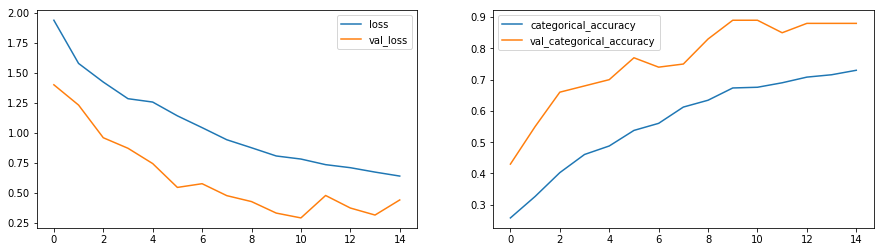

In [18]:
start_frame = 5
seq_len = 15
im_height = 120
im_width = 120
channels = 3
batch_size=8
epochs=15

model9 = Sequential()
model9.add(TimeDistributed(mobilenet.MobileNet(weights='imagenet', include_top=False),input_shape=(seq_len,im_height,im_width,channels)))
# for layer in model8.layers:
#     layer.trainable = False


model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((2, 2))))
model9.add(TimeDistributed(Flatten()))

model9.add(GRU(128))
model9.add(Dropout(0.5))

model9.add(Dense(64,activation='relu'))
model9.add(Dropout(0.5))

model9.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam(lr=0.0002)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

mbn_gru1=Builder('mbn_gru1',model9,image_shape=(im_height,im_width,channels),
                 batch_size=batch_size,epochs=epochs,sequence_length=seq_len,start_frame=start_frame,
                 data_augment=True)
t0=time.time()
mbn_gru1_result=mbn_gru1.train_model()
timetaken.append(['mbn_gru1',batch_size,time.time()-t0])

In [22]:
model9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 15, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
__________